In [10]:
import torch
import sys
import os

sys.path.append('..')

In [86]:
from torch.utils.data import DataLoader

from dataset import get_dataset
from datasets.gqn import Scene
from models import get_model_genesis as get_model
from preprocess import Dummy, Quantization, Range

from torchvision.utils import make_grid
from matplotlib.pyplot import imshow, figure, scatter, colorbar, hist
import matplotlib.pyplot as plt
import matplotlib as mpl

use_gpu = torch.cuda.is_available()
device = torch.device('cuda' if use_gpu else 'cpu')
num_gpus = torch.cuda.device_count()

In [34]:
# Get dataset
dataset = 'rooms_ring_camera'
data_root = '/data/public/rw/datsets/gqn/torch'
batch_size = 32
data = get_dataset(dataset, data_root, batch_size)

kwargs = {
    'pin_memory': True if use_gpu else False,
    'shuffle': False,
    'num_workers': num_gpus * 4
}

loader = DataLoader(data['test'], batch_size * num_gpus, **kwargs)

In [92]:
data1, _ = data['train'][0]
dims = list(data1.shape)
param = dict(
    zdim=64,
    hdim=128,
    quant=False,
    layers=7,
    sigma=0.7
)
model, optimizaer = get_model('genesis', 1e-4, param, *dims)
if param['quant']:
    q = Quantization()
else:
    q = Range()

def view_image(img):
    imshow(img.cpu().numpy().transpose(1,2,0))
    
def view_images(t):
    t_grid = make_grid(t,nrow=3)
    imshow(t_grid.cpu().numpy().transpose(1,2,0),interpolation='nearest')

In [93]:
logroot = '/data/private/exp/genesis/rooms_ring_camera_vae'
log = 'modelgenesis_batch_size64_epoch300_num_gpu4_lr0.0001_zdim64_hdim128_quantFalse_layers7_sigma0.7/Nov29-1115'
filename = 'checkpoints/epoch_model_300.pth'
filepath = os.path.join(logroot, log, filename)
saved = torch.load(filepath)
model.load_state_dict(saved)

FileNotFoundError: [Errno 2] No such file or directory: '/data/private/exp/genesis/rooms_ring_camera_vae/modelgenesis_batch_size64_epoch300_num_gpu4_lr0.0001_zdim64_hdim128_quantFalse_layers7_sigma0.7/Nov29-1115/checkpoints/epoch_model_300.pth'

In [57]:
model.eval()
model.to(device)

Genesis(
  (mask_vae): GatedRecurrentSBP(
    (core): VAE(
      (q_z_nn): Sequential(
        (0): GatedConv2d(
          (sigmoid): Sigmoid()
          (conv): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (h_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (g_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): GatedConv2d(
          (sigmoid): Sigmoid()
          (conv): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
          (h_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (g_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (2): GatedConv2d(
          (sigmoid): Sigmoid()
          (conv): Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (h_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [59]:
with torch.no_grad():
    x, _ = data['test'][0]
    x = x.view(1, 3, 64, 64)
    x_p = q.preprocess(x)
    x_p = x_p.to(device)
    recon_p, recon_k_p, x_mu_k, ms_k, kl_m, kl_c = model(x_p)
    recon = q.postprocess(recon_p)
    recon_k = q.postprocess(recon_k_p)
    

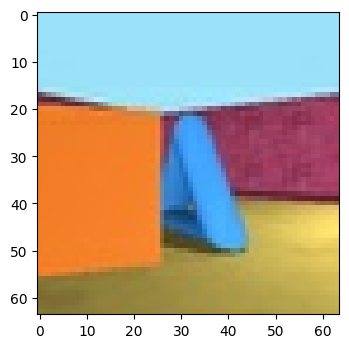

In [60]:
view_image(x.view(3, 64, 64))

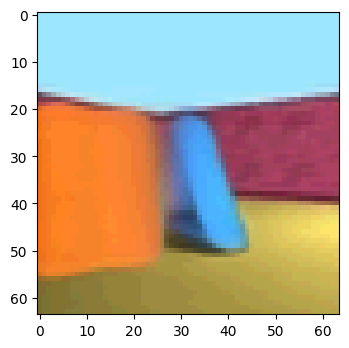

In [62]:
view_image(recon.view(3, 64, 64))

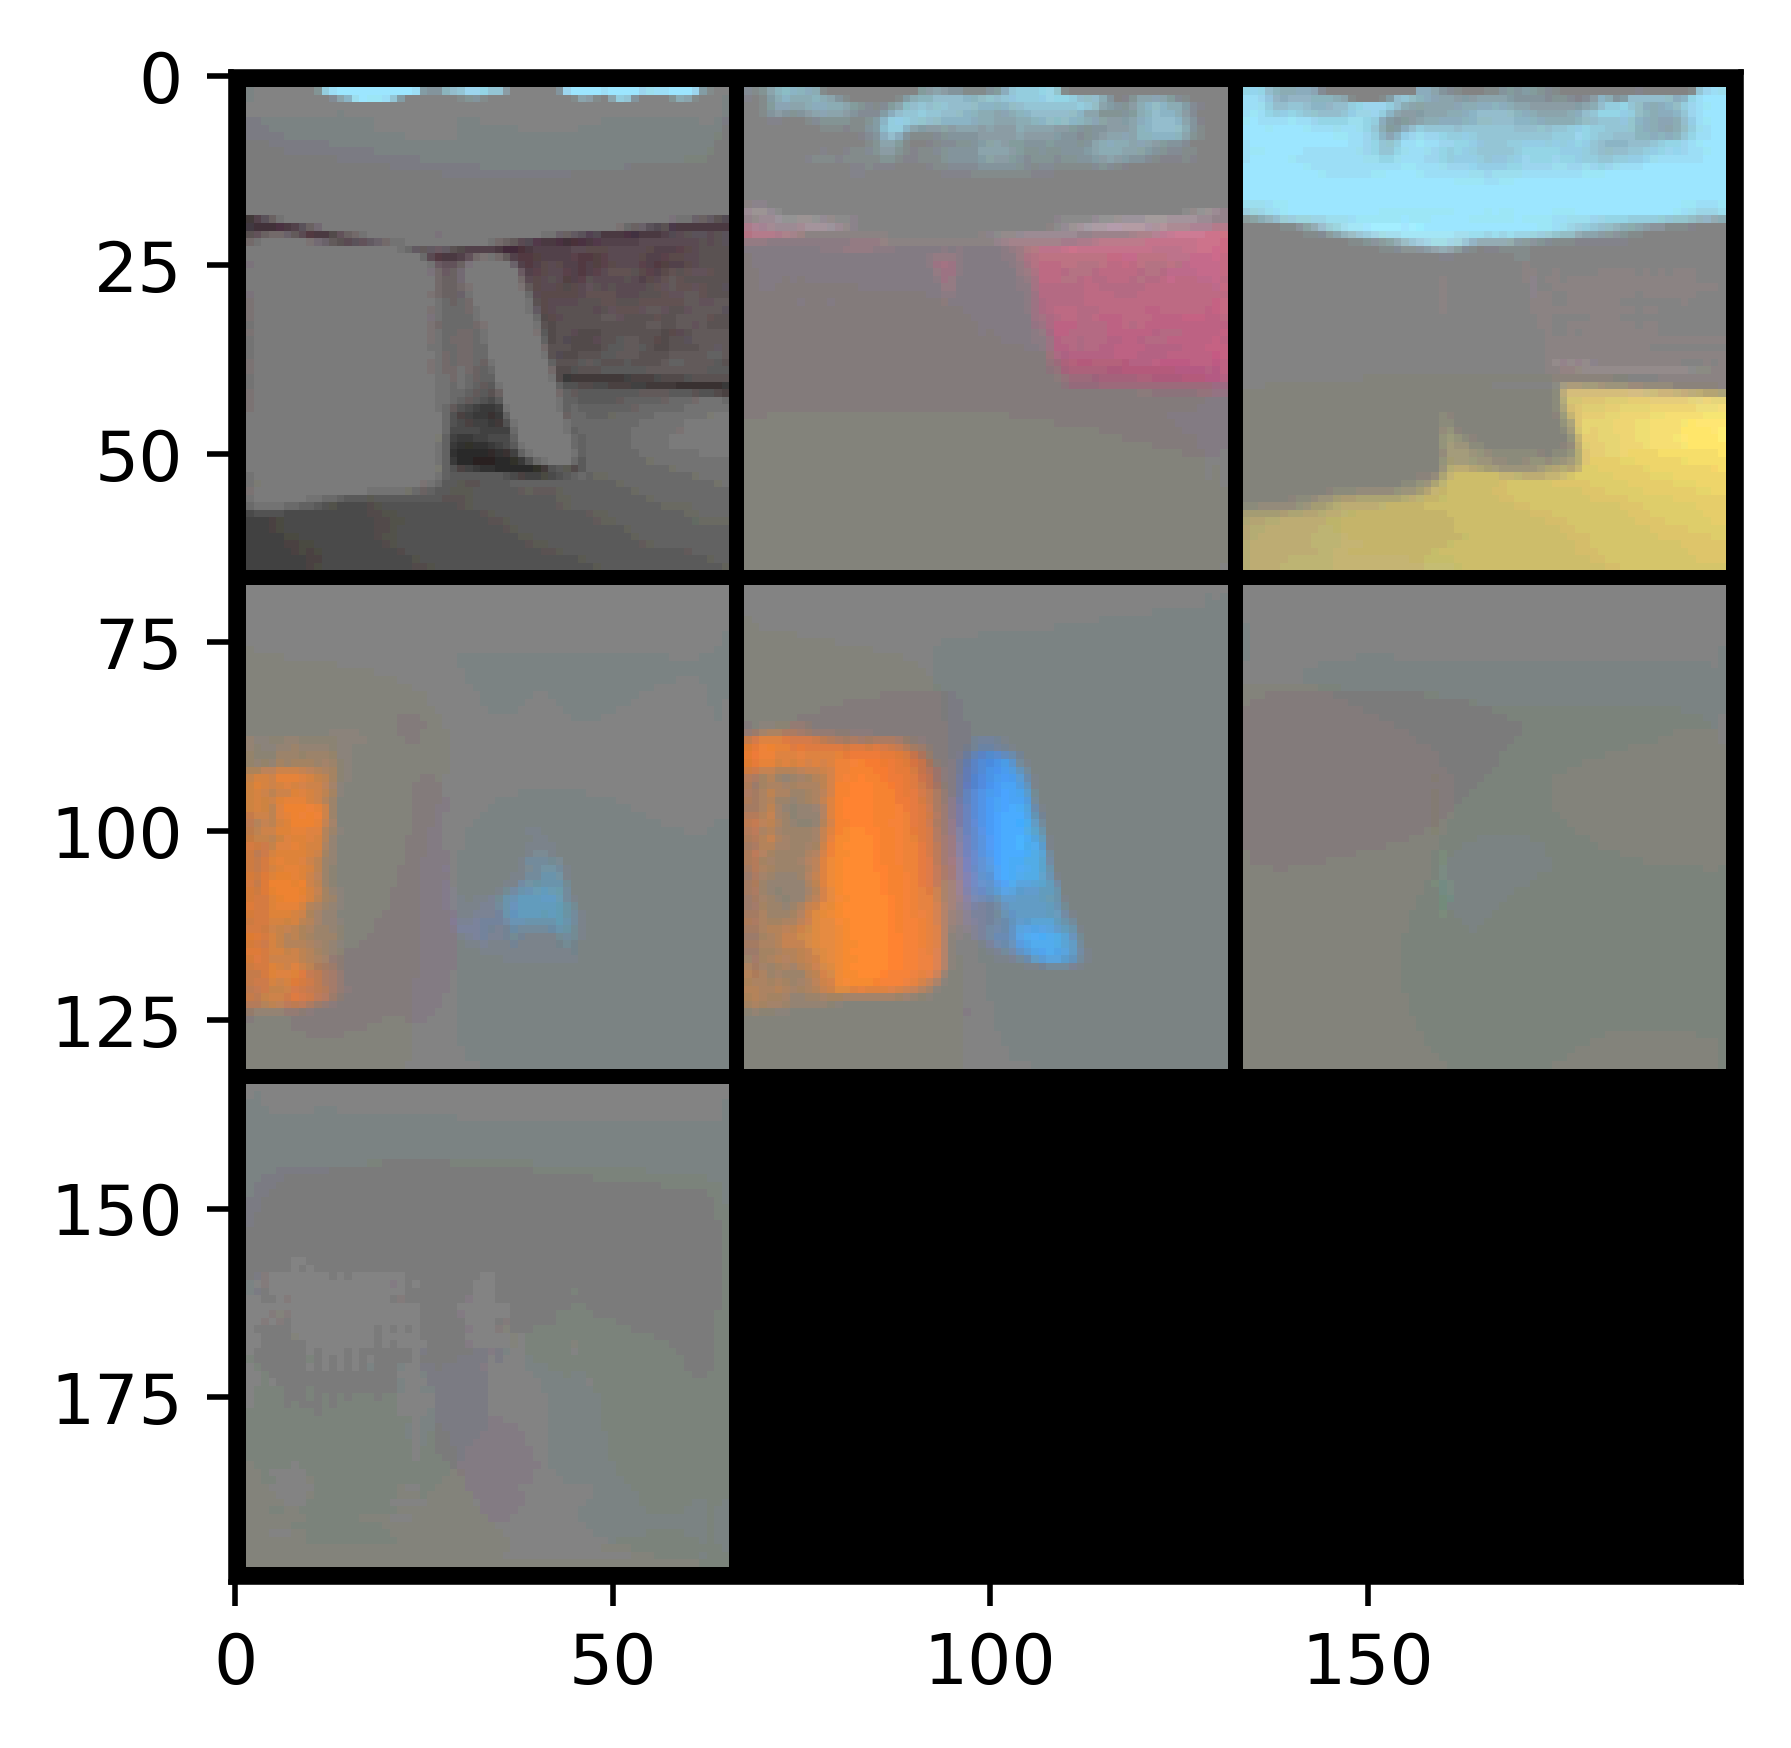

In [70]:
mpl.rcParams['figure.dpi'] = 500

view_images(recon_k.squeeze(0).permute(3, 0, 1, 2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


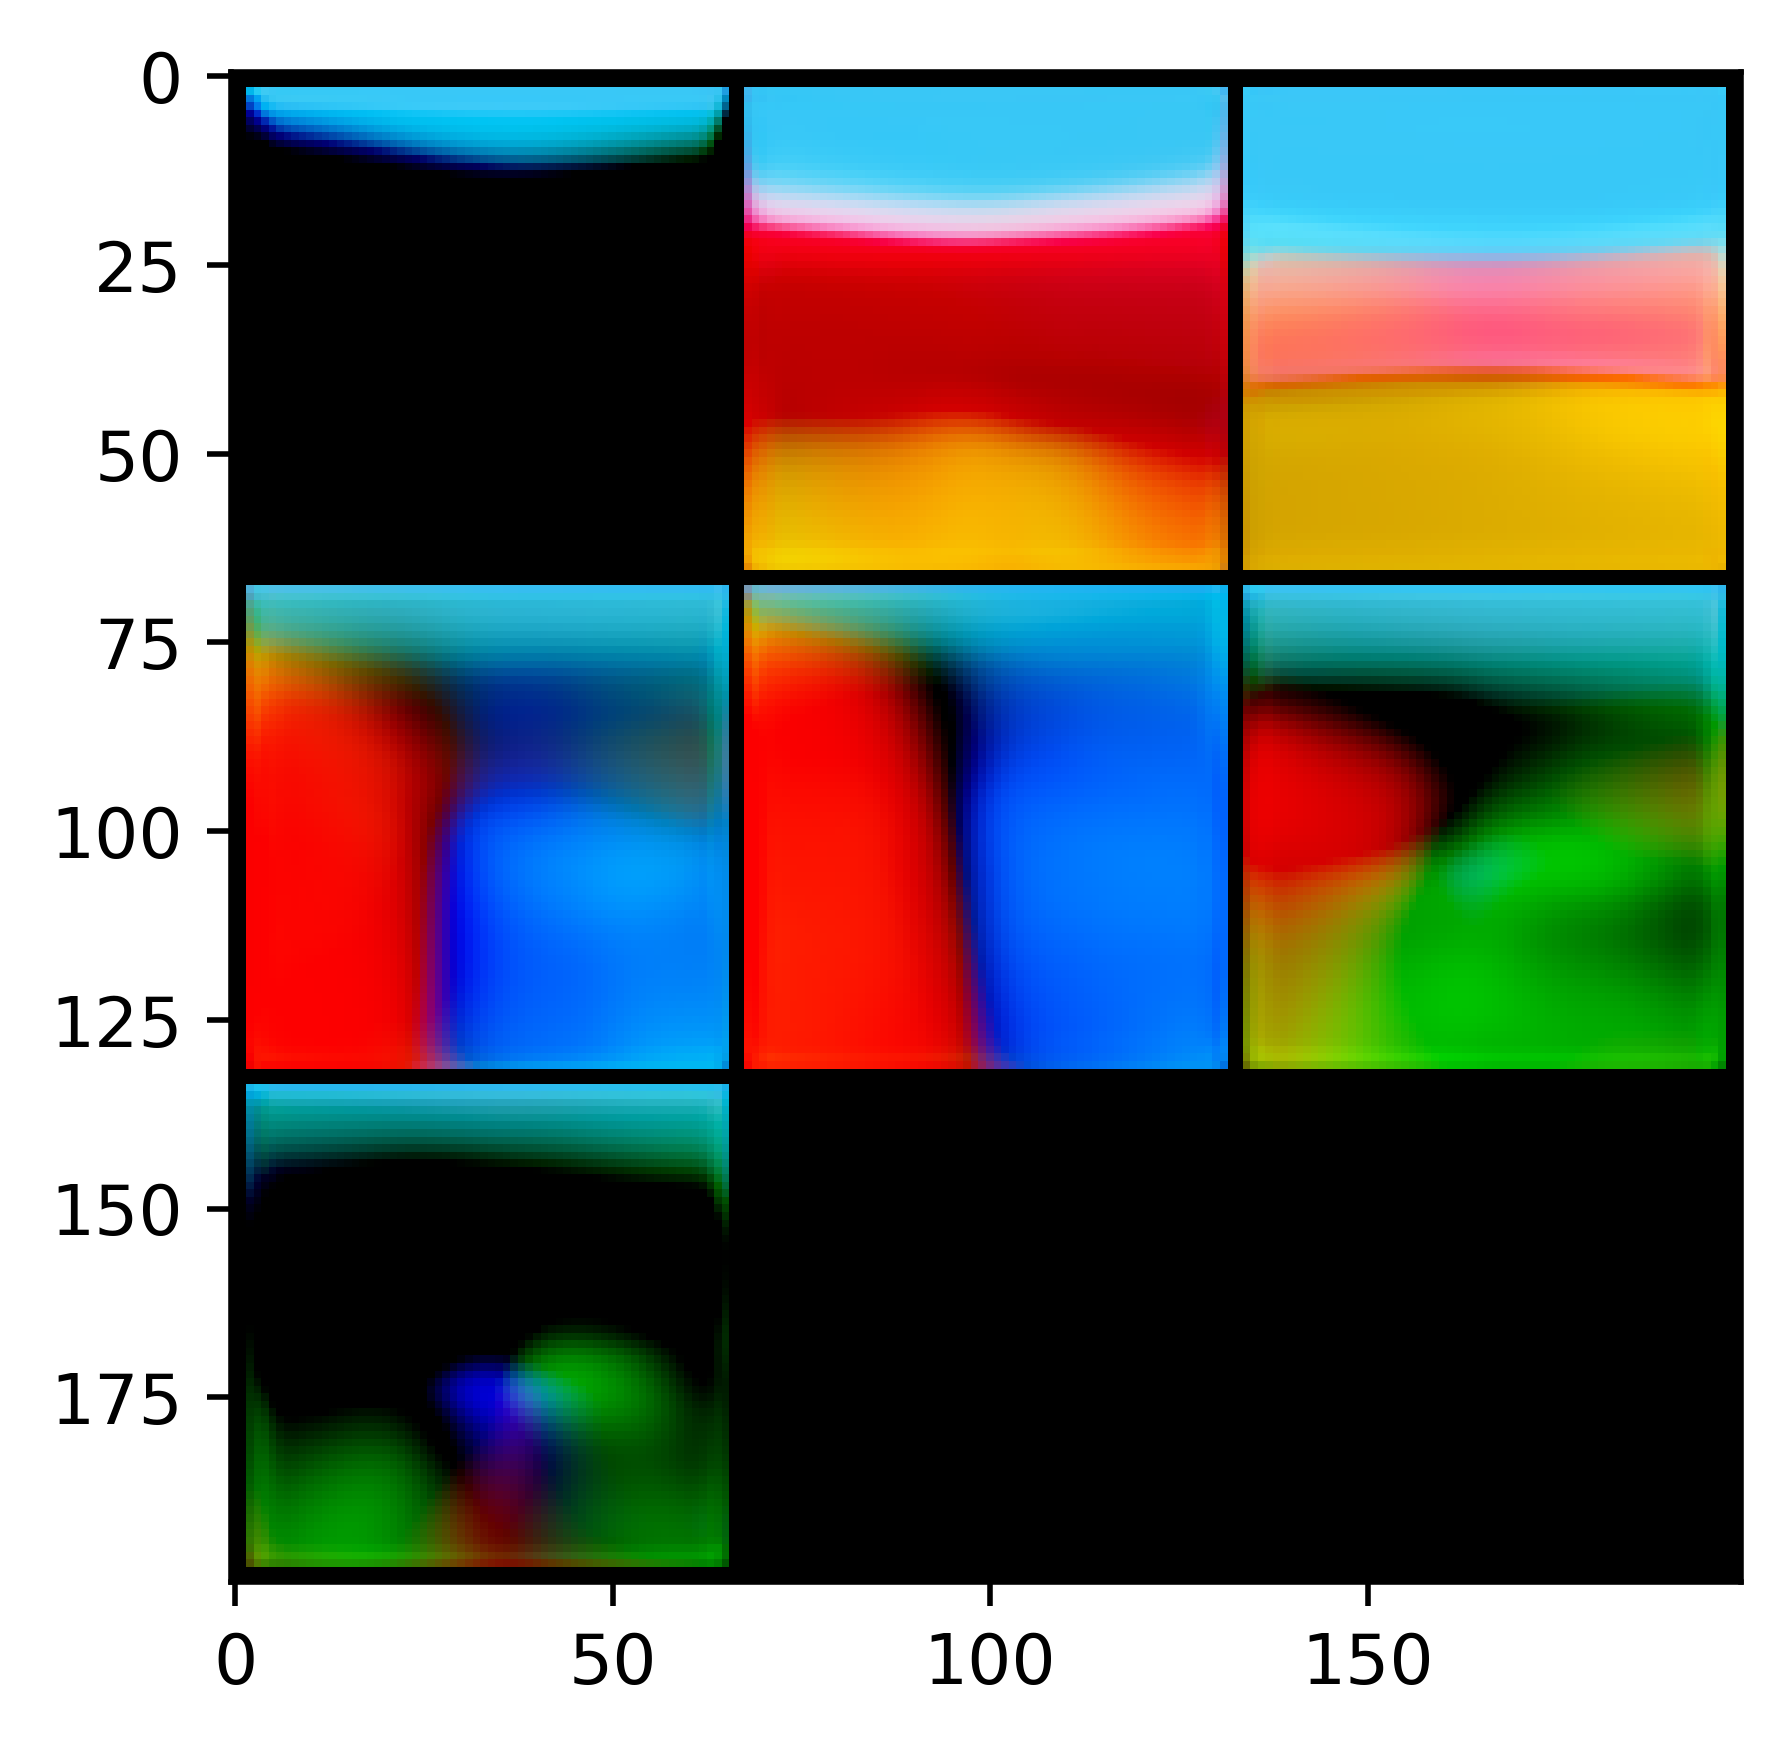

In [74]:
mpl.rcParams['figure.dpi'] = 500
view_images(x_mu_k.squeeze(0).permute(3, 0, 1, 2))

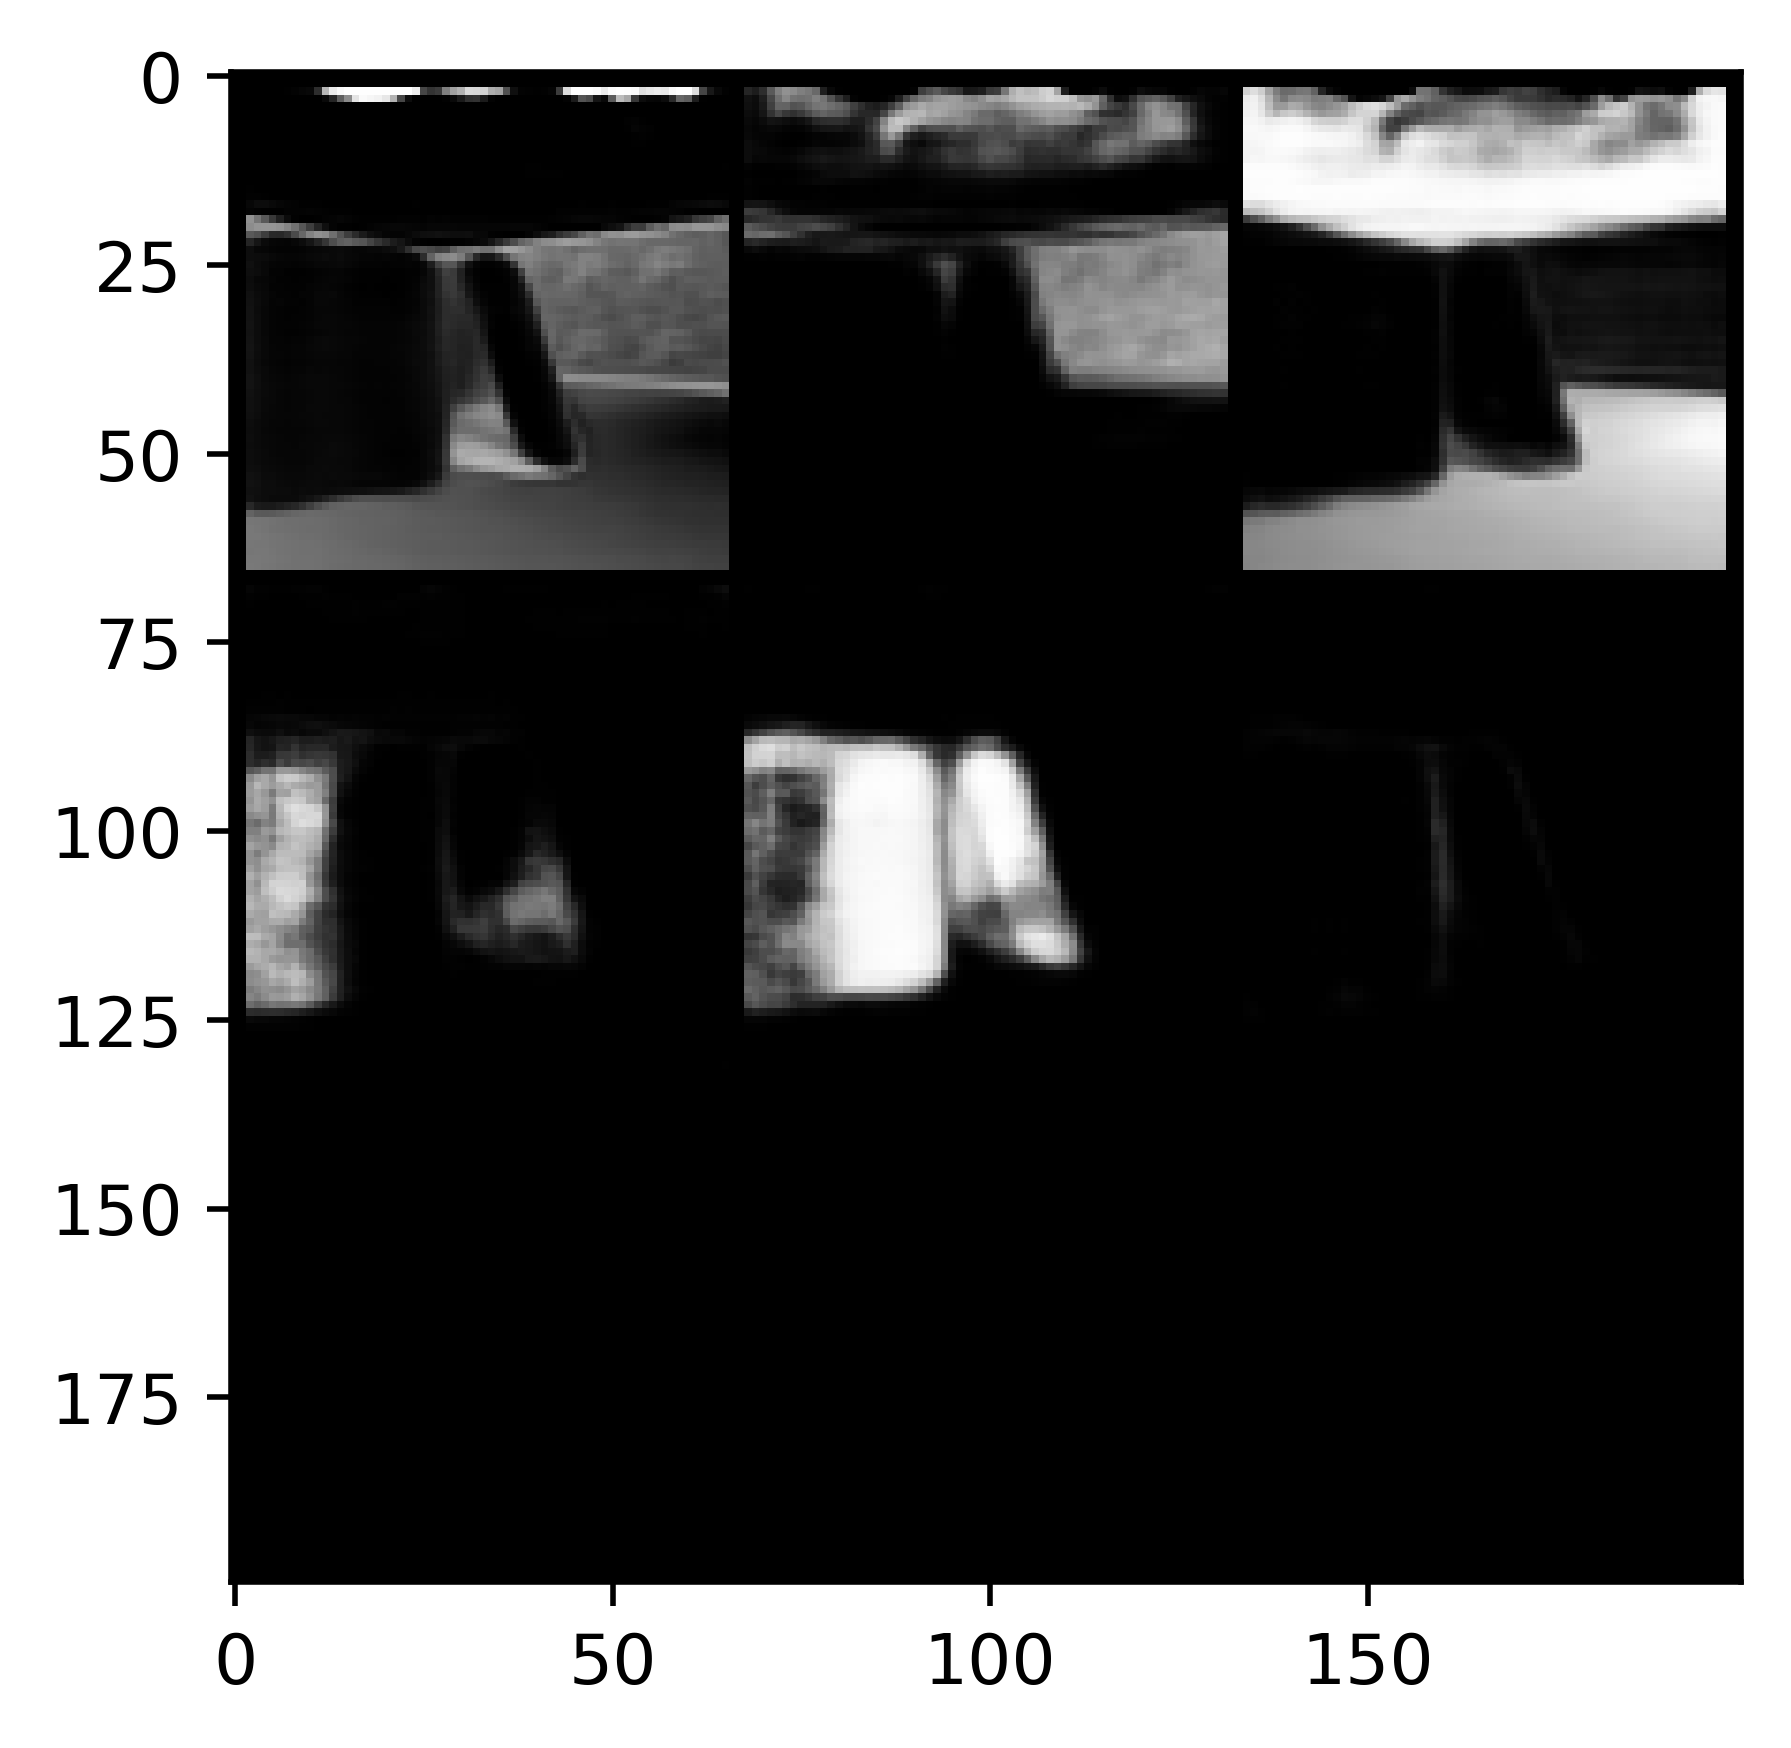

In [75]:
mpl.rcParams['figure.dpi'] = 500
view_images(ms_k.squeeze(0).permute(3, 0, 1, 2))

(array([18082.,   834.,   661.,   411.,   293.,   228.,   256.,   227.,
          142.,   143.,   102.,   108.,   107.,   112.,    92.,    94.,
          102.,    81.,    96.,    84.,    89.,    81.,    88.,    84.,
           74.,    88.,   102.,    96.,    87.,   118.,   114.,   116.,
           91.,   107.,   109.,   114.,   102.,   109.,   100.,    88.,
           81.,    73.,    64.,    60.,    75.,    55.,    79.,    74.,
           46.,    54.,    49.,    58.,    68.,    76.,    84.,    83.,
           85.,   102.,    99.,    86.,    89.,    79.,    70.,    77.,
           81.,    59.,    80.,    86.,    50.,    60.,    68.,    55.,
           70.,    69.,    76.,    58.,    61.,    52.,    59.,    47.,
           63.,    63.,    55.,    61.,    44.,    54.,    44.,    48.,
           42.,    35.,    46.,    50.,    58.,    57.,    89.,    96.,
          117.,   184.,   231.,   226.]),
 array([1.0932071e-29, 9.9999337e-03, 1.9999867e-02, 2.9999800e-02,
        3.9999735e-02, 4.9

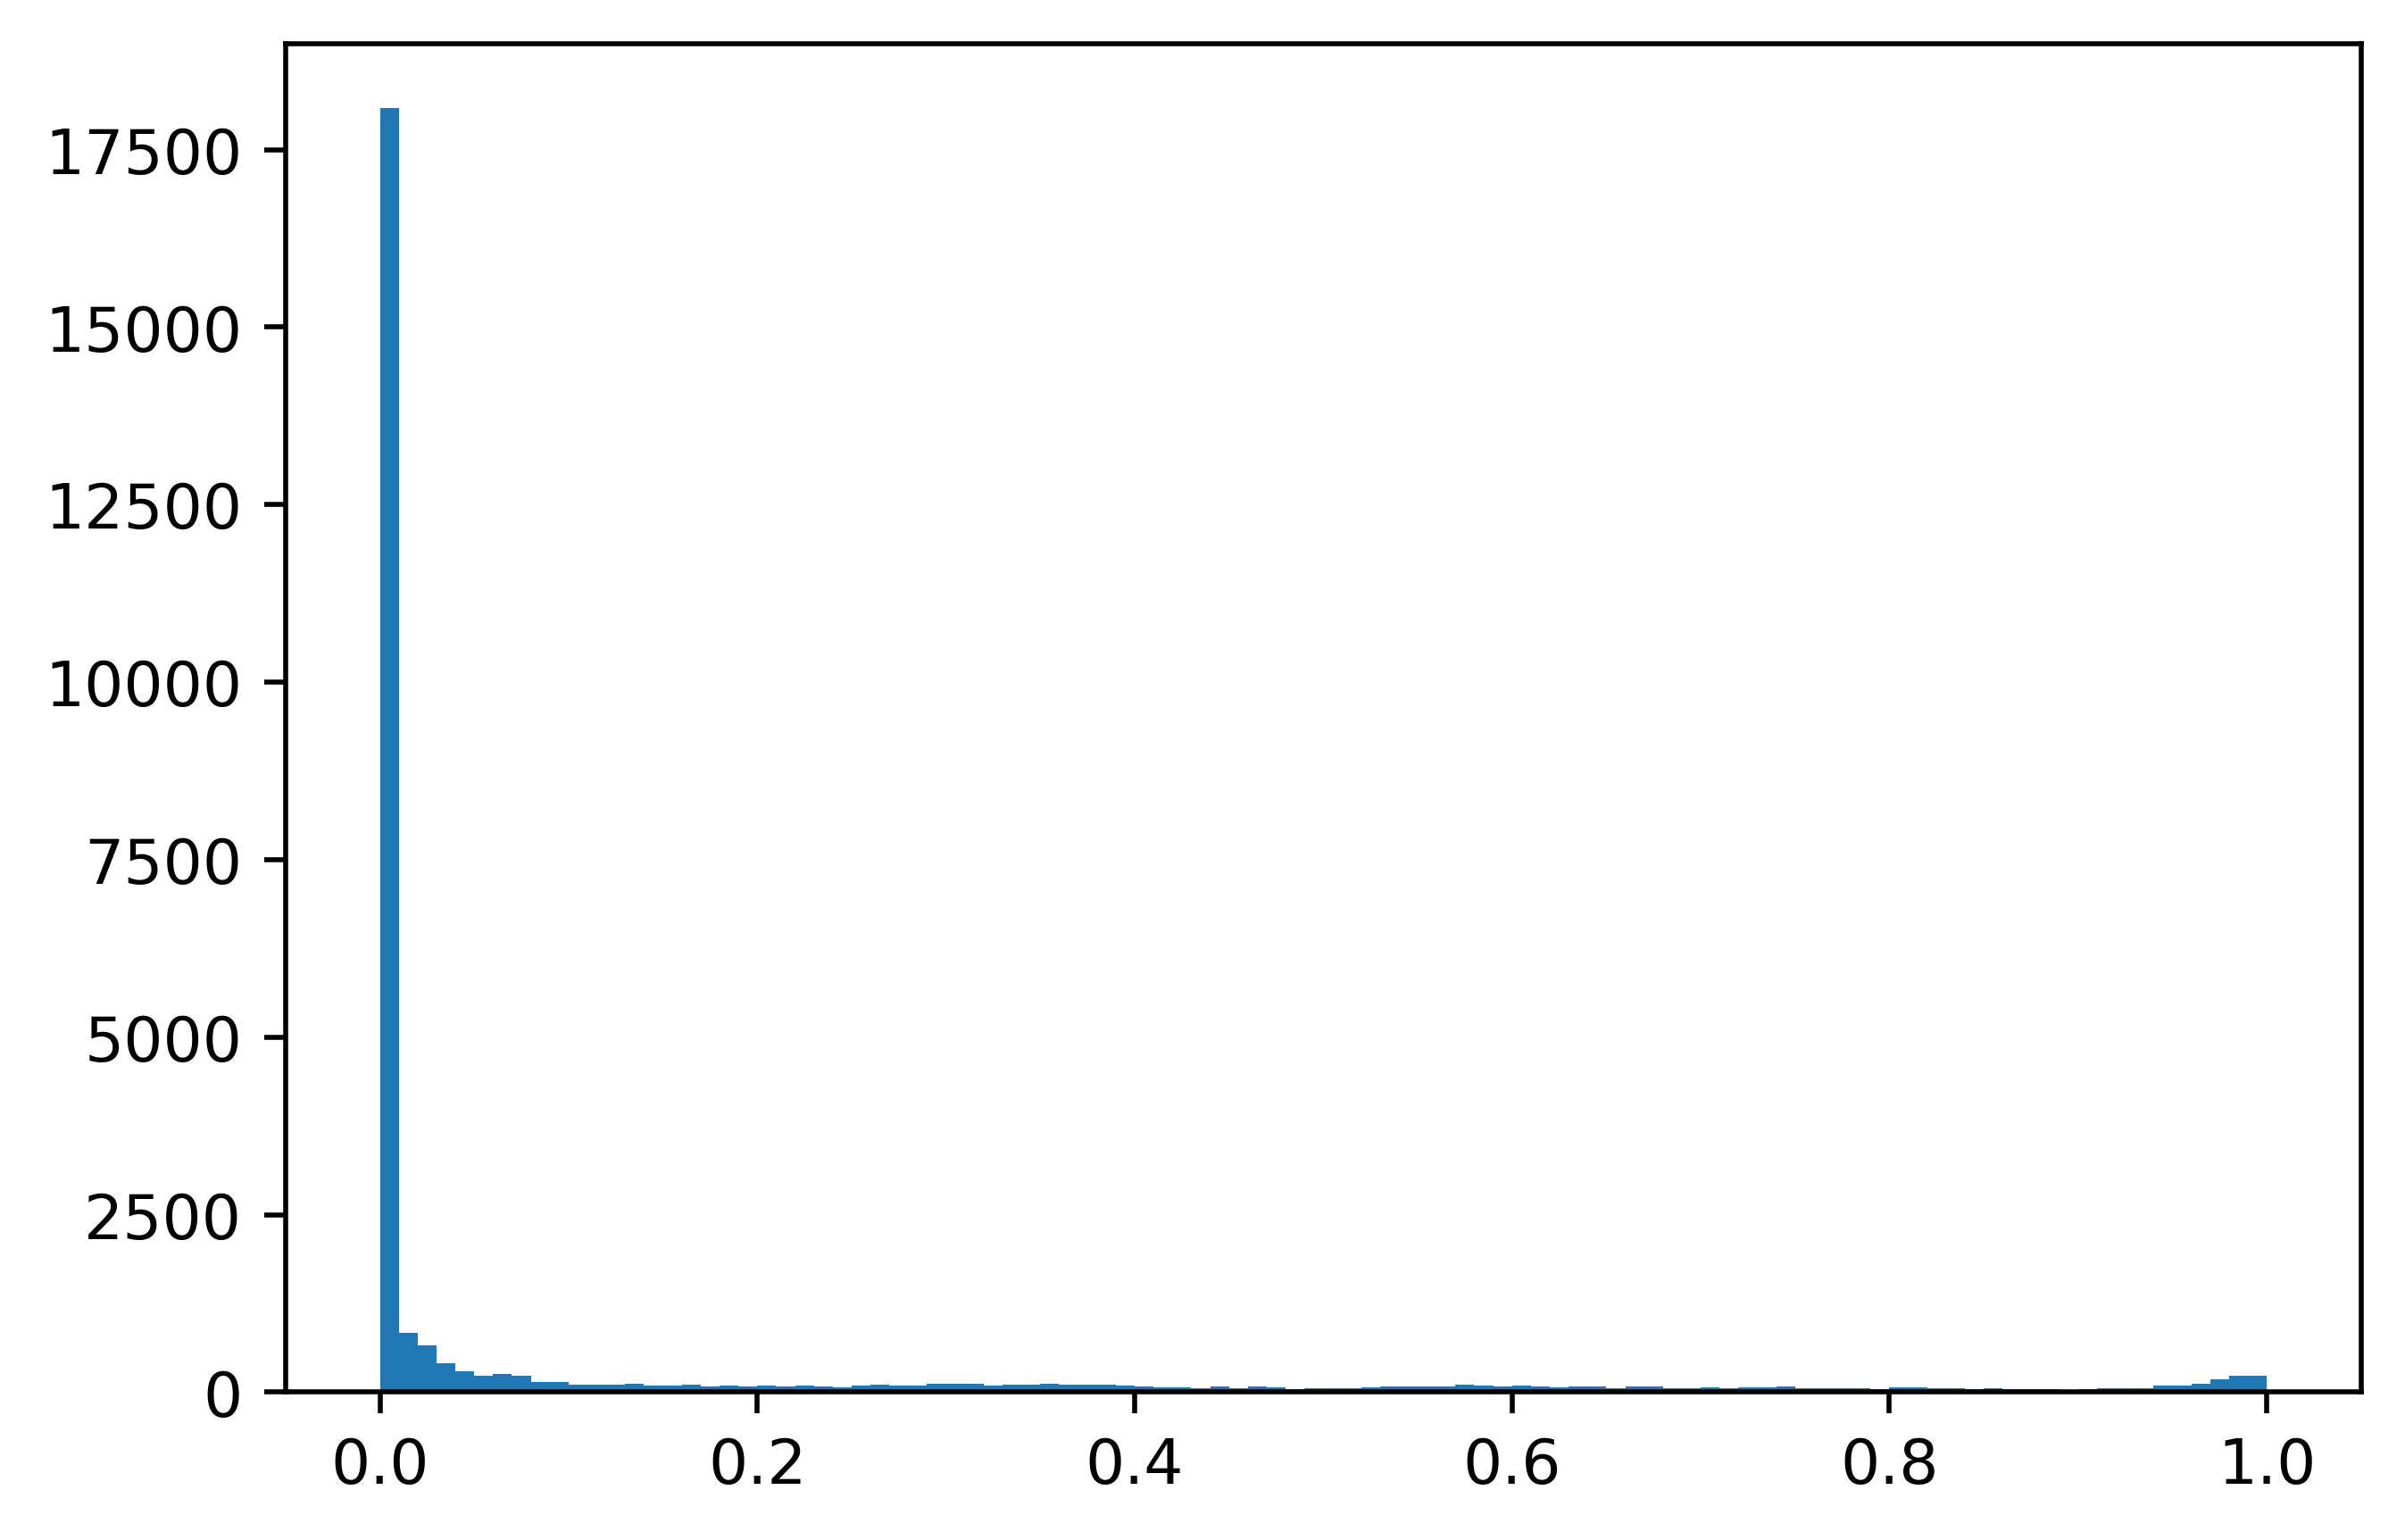

In [94]:
ms_1 = ms_k[0, 0, :, :, ]
ms_1.shape
hist(ms_1.view(-1).cpu().numpy(),100)